# Business Problem
- In order for the company to plan for the medium to long term, it is necessary to estimate the potential value that existing customers will provide to the company in the future.

# Dataset

- The dataset has information on 100,000 orders made from 2016 to 2018 across multiple marketplaces in Brazil. 

- **Customer data set:** 117601 observations, 3 variables

    - **order_id:** Order number
    - **customer_id:** Customer number
    - **payment_value:** Total price paid by the customer

- **Order data set:** 99441 observations, 2 variables

    - **order_id:** Order number
    - **order_purchase_timestamp:** Date of customer purchase

# SET UP THE ENVIRONMENT

In [1213]:
!pip install lifetimes plotly

In [1214]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from datetime import timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import warnings

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes.plotting import plot_period_transactions, plot_calibration_purchases_vs_holdout_purchases

warnings.simplefilter(action="ignore")

In [1215]:
# Adjusting Row Column Settings
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.4f' % x)

# LOAD DATA

In [1216]:
# Loading the Data Set
df1 = pd.read_csv('order.csv')
df2 = pd.read_csv('customer.csv')

In [1217]:
df1.head()

,order_purchase_timestamp,order_id
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7
1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451
2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d
3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a
4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159


In [1218]:
df2.head()

,order_id,customer_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,72.1900
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,259.8300
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,216.8700
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,25.7800
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,218.0400


In [1219]:
df = pd.merge(df1,df2,on="order_id", how = "inner" )

In [1220]:
df.head()

,order_purchase_timestamp,order_id,customer_id,payment_value
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,18.1200
1,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,2.0000
2,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,18.5900
3,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,141.4600
4,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,179.1200


# DATA UNDERSTANDING

In [1221]:
# Preliminary examination of the data set
def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('\n')
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('\n')
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('\n')
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('\n')
    print('##################### NA #####################')
    print(dataframe.isnull().sum())

check_df(df)

##################### Shape #####################
(117601, 4)


##################### Types #####################
order_purchase_timestamp     object
order_id                     object
customer_id                  object
payment_value               float64
dtype: object


##################### Head #####################
  order_purchase_timestamp                          order_id  \
0      2017-10-02 10:56:33  e481f51cbdc54678b7cc49136f2d6af7   
1      2017-10-02 10:56:33  e481f51cbdc54678b7cc49136f2d6af7   
2      2017-10-02 10:56:33  e481f51cbdc54678b7cc49136f2d6af7   
3      2018-07-24 20:41:37  53cdb2fc8bc7dce0b6741e2150273451   
4      2018-08-08 08:38:49  47770eb9100c2d0c44946d9cf07ec65d   

                        customer_id  payment_value  
0  3504c0cb71d7fa48d967e0e4c94d59d9        18.1200  
1  3504c0cb71d7fa48d967e0e4c94d59d9         2.0000  
2  3504c0cb71d7fa48d967e0e4c94d59d9        18.5900  
3  289cdb325fb7e7f891c38608bf9e0962       141.4600  
4  4869f7a5dfa277a7dca6462d

In [1222]:
# Examination of numerical and categorical variables

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.
    Parameters
    ------
         dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables
    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 117601
Variables: 4
cat_cols: 0
num_cols: 1
cat_but_car: 3
num_but_cat: 0


In [1223]:
# clean up column names
df = df.rename(columns={"payment_value": "TotalPrice", "order_purchase_timestamp": "InvoiceTimestamp"})

In [1224]:
# convert TotalPrice in Euro using a fixed conversion rate
REAL_EURO_CONVERSION_RATE = 0.20
df["TotalPriceEuro"] = df["TotalPrice"]*REAL_EURO_CONVERSION_RATE

In [1225]:
# convert InvoceDate (now InvoceTimestamp) to an actual date
df['InvoiceTimestamp'] = pd.to_datetime(df['InvoiceTimestamp'])

# Now that 'InvoiceTimestamp' is a datetime column, you can extract the date part
df['InvoiceDate'] = df['InvoiceTimestamp'].dt.date

In [1226]:
df.head()

,InvoiceTimestamp,order_id,customer_id,TotalPrice,TotalPriceEuro,InvoiceDate
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,18.1200,3.6240,2017-10-02
1,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,2.0000,0.4000,2017-10-02
2,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,18.5900,3.7180,2017-10-02
3,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,141.4600,28.2920,2018-07-24
4,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,179.1200,35.8240,2018-08-08


In [1227]:
# drop duplicates
df= df.drop_duplicates()

Since Customer Lifetime Value (CLTV) modeling is subject to outliers we should evaluate their distribution starting from raw data

In [1228]:
df.drop(columns=['InvoiceTimestamp']).describe(percentiles=[.01,.05,.10,.25,.5,.75,.9,.95,.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
TotalPrice,103881.0000,155.7816,216.8858,0.0000,7.5380,27.2900,35.7700,57.6800,101.4600,174.0400,301.3500,442.5900,1038.6280,13664.0800
TotalPriceEuro,103881.0000,31.1563,43.3772,0.0000,1.5076,5.4580,7.1540,11.5360,20.2920,34.8080,60.2700,88.5180,207.7256,2732.8160


The distribution of payment values is highly skewed, as indicated by the mean being higher than the median, and most data clustering at the lower end of the scale.
The substantial difference between the maximum value and the 99th percentile suggests the presence of extreme outliers in the dataset.
The standard deviation being larger than the mean further confirms the presence of significant variability in payment sizes, which might be influenced by a few high-value transactions.

 Let's Grab and Suppress Outliers

In [1229]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[dataframe[variable] < low_limit, variable] = round(low_limit, 0)
    dataframe.loc[dataframe[variable] > up_limit, variable] = round(up_limit, 0)

Note: When calculating cltv, frequency values must be integers. Therefore, round the lower and upper limits with round().

In [1230]:
replace_with_thresholds(df, 'TotalPrice')
replace_with_thresholds(df, 'TotalPriceEuro')

In [1231]:
df.drop(columns=['InvoiceTimestamp']).describe(percentiles=[.01,.05,.10,.25,.5,.75,.9,.95,.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
TotalPrice,103881.0000,155.0260,201.9590,0.0000,7.5380,27.2900,35.7700,57.6800,101.4600,174.0400,301.3500,442.5900,1038.6280,2585.0000
TotalPriceEuro,103881.0000,31.0052,40.3918,0.0000,1.5076,5.4580,7.1540,11.5360,20.2920,34.8080,60.2700,88.5180,207.7256,517.0000


# CUSTOMER TABLE

In [1232]:
MAX_INVOICE_DATE = (df["InvoiceDate"].max()) + pd.Timedelta(days=1)
MAX_INVOICE_DATE

datetime.date(2018, 9, 4)

In [1233]:
df_clean_for_lifetime = df.groupby(['customer_id','InvoiceDate']).agg(TotalPriceEuro=('TotalPriceEuro','sum')).reset_index()
df_clean_for_lifetime.head()

,customer_id,InvoiceDate,TotalPriceEuro
0,0015a82c2db000af6aaaf3ae2ecb0532,2017-09-26,183.2040
1,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-12,183.2040
2,0015a82c2db000af6aaaf3ae2ecb0532,2017-10-18,183.2040
3,001cca7ae9ae17fb1caed9dfb1094831,2017-02-04,24.2100
4,001cca7ae9ae17fb1caed9dfb1094831,2017-02-18,114.7700


In [1234]:
df_customer_table = (
  summary_data_from_transaction_data(
    df_clean_for_lifetime,
    customer_id_col='customer_id',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPriceEuro',
    observation_period_end = MAX_INVOICE_DATE, 
    freq='D'
    )
)
df_customer_table.head()

,frequency,recency,T,monetary_value
customer_id,,,,
0015a82c2db000af6aaaf3ae2ecb0532,2.0000,22.0000,343.0000,183.2040
001cca7ae9ae17fb1caed9dfb1094831,152.0000,523.0000,577.0000,44.6041
001e6ad469a905060d959994f1b41e4f,0.0000,0.0000,28.0000,0.0000
002100f778ceb8431b7a1020ff7ab48f,41.0000,210.0000,355.0000,10.6226
003554e2dce176b5555353e4f3555ac8,0.0000,0.0000,263.0000,0.0000


Exlcude customers with only one purchase since the models won't be able to compute their CLTV.

In [1235]:
df_customer_table = df_customer_table[(df_customer_table['frequency'] > 1) & (df_customer_table['monetary_value'] > 1)]

In [1236]:
df_customer_table.describe(percentiles=[.01,.05,.10,.25,.5,.75,.9,.95,.99]).T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
frequency,2161.0000,30.5238,53.5186,2.0000,2.0000,2.0000,2.0000,5.0000,11.0000,32.0000,78.0000,123.0000,278.6000,536.0000
recency,2161.0000,243.4632,177.3269,2.0000,11.6000,25.0000,45.0000,94.0000,205.0000,365.0000,524.0000,565.0000,684.0000,710.0000
T,2161.0000,346.6913,191.8186,15.0000,31.0000,63.0000,89.0000,171.0000,335.0000,525.0000,585.0000,694.0000,700.0000,730.0000
monetary_value,2161.0000,45.8721,57.1548,4.1547,7.0391,10.2471,12.5123,18.8360,30.3051,49.2261,89.2273,134.0039,302.3970,991.5910


In [1237]:
df_customer_table[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.0000,0.0049
monetary_value,0.0049,1.0000


Perform a train-test split to avoid the phenomenon of overfitting.

In [1238]:
holdout_days = 90
calibration_end_date = MAX_INVOICE_DATE - timedelta(days = holdout_days)

df_customer_table_cal = (
  calibration_and_holdout_data(
    df_clean_for_lifetime,
    customer_id_col='customer_id',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPriceEuro',
    observation_period_end = MAX_INVOICE_DATE,
    calibration_period_end = calibration_end_date,
    freq='D'    
    )
)

df_customer_table_cal.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,2.0000,22.0000,253.0000,183.2040,0.0000,0.0000,90.0000
001cca7ae9ae17fb1caed9dfb1094831,149.0000,448.0000,487.0000,44.8283,3.0000,33.4687,90.0000
002100f778ceb8431b7a1020ff7ab48f,41.0000,210.0000,265.0000,10.6226,0.0000,0.0000,90.0000
003554e2dce176b5555353e4f3555ac8,0.0000,0.0000,173.0000,0.0000,0.0000,0.0000,90.0000
004c9cd9d87a3c30c522c48c4fc07416,125.0000,461.0000,495.0000,36.4121,0.0000,0.0000,90.0000


Exlcude customers with only one purchase in calibration since the models won't be able to compute their CLTV.

In [1239]:
df_customer_table_cal = df_customer_table_cal[(df_customer_table_cal['frequency_cal'] > 1) & (df_customer_table_cal['monetary_value_cal'] > 1)]

In [1240]:
# Getting the top 20 largest values in the 'frequency_cal' column
top_20_frequency_cal = df_customer_table_cal['frequency_cal'].nlargest(20)
print(top_20_frequency_cal)

customer_id
4a3ca9315b744ce9f8e9374361493884   463.0000
cc419e0650a3c5ba77189a1882b7556a   428.0000
7a67c85e85bb2ce8582c35f2203ad736   427.0000
6560211a19b47992c3666cc44a7e94c0   422.0000
da8622b14eb17ae2831f4ac5b9dab84a   370.0000
3d871de0142ce09b7081e2b9d1733cb1   358.0000
7c67e1448b00f6e969d365cea6b010ab   337.0000
cca3071e3e9bb7d12640c9fbe2301306   335.0000
1f50f920176fa81dab994f9023523100   330.0000
f8db351d8c4c4c22c6835c19a46f01b0   313.0000
4869f7a5dfa277a7dca6462dcf3b52b2   288.0000
620c87c171fb2a6dd6e8bb4dec959fc6   284.0000
e9779976487b77c6d4ac45f75ec7afe9   284.0000
fa1c13f2614d7b5c4749cbc52fecda94   284.0000
a1043bafd471dff536d0c462352beb48   279.0000
391fc6631aebcf3004804e51b40bcf1e   278.0000
d2374cbcbb3ca4ab1086534108cc3ab7   267.0000
85d9eb9ddc5d00ca9336a2219c97bb13   266.0000
ea8482cd71df3c1969d7b9473ff13abc   256.0000
128639473a139ac0f3e5f5ade55873a5   250.0000
Name: frequency_cal, dtype: float64


# CLTV MODELING

## Establishment of BG-NBD Model

In [1241]:
# Create model object
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [1242]:
# Model fitting
bgf.fit(df_customer_table_cal['frequency_cal'],
        df_customer_table_cal['recency_cal'],
        df_customer_table_cal['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 1784 subjects, a: 0.19, alpha: 10.00, b: 3.82, r: 1.15>

In [1243]:
# score the model

def score_model(actuals, predicted, metric='mse'):
  # make sure metric name is lower case
  metric = metric.lower()
  
  # Mean Squared Error and Root Mean Squared Error
  if metric=='mse' or metric=='rmse':
    val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    if metric=='rmse':
        val = np.sqrt(val)
  
  # Mean Absolute Error
  elif metric=='mae':
    np.sum(np.abs(actuals-predicted))/actuals.shape[0]
  
  else:
    val = None
  
  return val

frequency_holdout_actual = df_customer_table_cal['frequency_holdout']
frequency_holdout_predicted = bgf.predict(df_customer_table_cal['duration_holdout'], df_customer_table_cal['frequency_cal'], df_customer_table_cal['recency_cal'], df_customer_table_cal['T_cal'])
mse = score_model(frequency_holdout_actual, frequency_holdout_predicted, 'rmse')


print('RMSE: {0}'.format(mse))

RMSE: 6.500475362066803


Since out actual frequencies range up to 450 or more, an RMSE of nearly 6 could be seen as relatively reasonable.

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

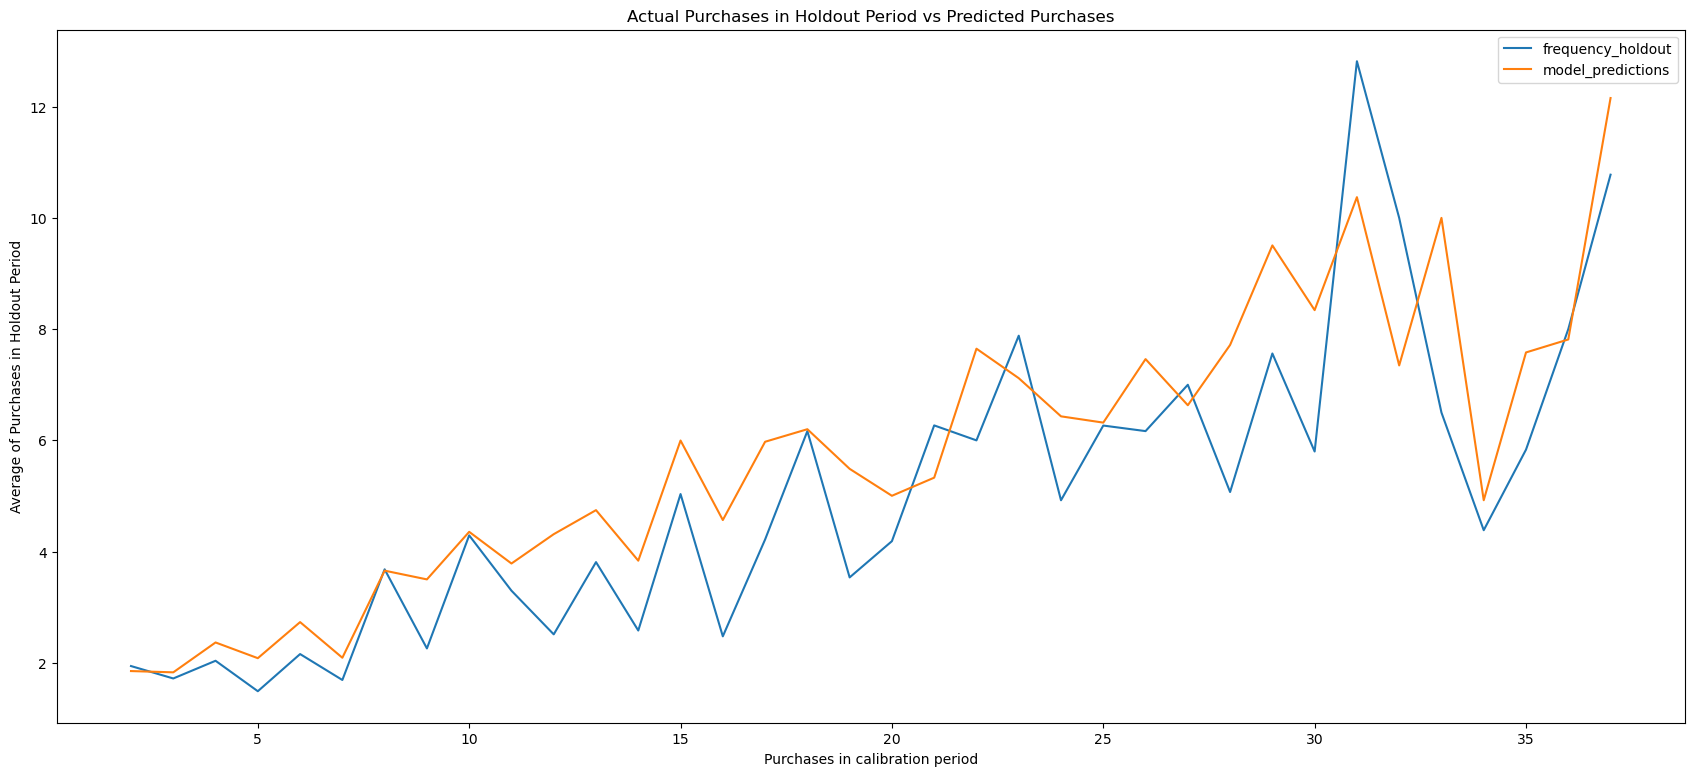

In [1244]:
plot_calibration_purchases_vs_holdout_purchases(
  bgf, 
  df_customer_table_cal,
  n=36,
  **{'figsize':(21,9)}
  )

## GAMMA-GAMMA MODEL

To estimate the economic value of each transaction we can use the Gamma-Gamma submodel.

In [1245]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(df_customer_table_cal['frequency_cal'], df_customer_table_cal['monetary_value_cal'])

<lifetimes.GammaGammaFitter: fitted with 1784 subjects, p: 3.82, q: 0.85, v: 3.75>

## Calculation of CLTV with BG-NBD and GG model

In [1246]:
df_customer_table_cal['cltv_3m'] = (
    ggf.customer_lifetime_value(
        bgf,
        df_customer_table_cal['frequency_cal'],
        df_customer_table_cal['recency_cal'],
        df_customer_table_cal['T_cal'],
        df_customer_table_cal['monetary_value_cal'],
        time=3, #months
        freq='D'
        )
)

In [1247]:
df_customer_table_cal['cltv_1y'] = (
    ggf.customer_lifetime_value(
        bgf,
        df_customer_table_cal['frequency_cal'],
        df_customer_table_cal['recency_cal'],
        df_customer_table_cal['T_cal'],
        df_customer_table_cal['monetary_value_cal'],
        time=12, #months
        freq='D'
        )
)

In [1248]:
df_customer_table_cal['cltv_3y'] = (
    ggf.customer_lifetime_value(
        bgf,
        df_customer_table_cal['frequency_cal'],
        df_customer_table_cal['recency_cal'],
        df_customer_table_cal['T_cal'],
        df_customer_table_cal['monetary_value_cal'],
        time=36, #months
        freq='D'
        )
)

In [1249]:
df_customer_table_cal["cltv_holdout"] = df_customer_table_cal["frequency_holdout"] * df_customer_table_cal["monetary_value_holdout"]

In [1250]:
df_customer_table_cal.loc[df_customer_table_cal["frequency_cal"]>50].head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,cltv_3m,cltv_1y,cltv_3y,cltv_holdout
customer_id,,,,,,,,,,,
001cca7ae9ae17fb1caed9dfb1094831,149.0000,448.0000,487.0000,44.8283,3.0000,33.4687,90.0000,4.3637,16.0654,40.1855,100.4060
004c9cd9d87a3c30c522c48c4fc07416,125.0000,461.0000,495.0000,36.4121,0.0000,0.0000,90.0000,72.8580,268.3831,671.7904,0.0000
00ee68308b45bc5e2660cd833c3f81cc,91.0000,258.0000,260.0000,51.3681,3.0000,40.4220,90.0000,1499.7928,5403.7910,13199.6304,121.2660
01fdefa7697d26ad920e9e0346d4bd1b,84.0000,376.0000,406.0000,32.8334,24.0000,32.2045,90.0000,254.4709,931.8326,2315.7724,772.9080
0241d4d5d36f10f80c644447315af0bd,106.0000,240.0000,241.0000,43.0033,48.0000,72.4997,90.0000,1569.3812,5636.6804,13726.7652,3479.9860


In [1251]:
df_clean_for_lifetime.loc[df_clean_for_lifetime["customer_id"]=='00ee68308b45bc5e2660cd833c3f81cc']

,customer_id,InvoiceDate,TotalPriceEuro
341,00ee68308b45bc5e2660cd833c3f81cc,2017-09-19,18.3540
342,00ee68308b45bc5e2660cd833c3f81cc,2017-09-24,39.1240
343,00ee68308b45bc5e2660cd833c3f81cc,2017-10-02,36.3820
344,00ee68308b45bc5e2660cd833c3f81cc,2017-10-03,21.3760
345,00ee68308b45bc5e2660cd833c3f81cc,2017-10-05,19.5620
346,00ee68308b45bc5e2660cd833c3f81cc,2017-10-16,20.9740
347,00ee68308b45bc5e2660cd833c3f81cc,2017-10-17,16.3460
348,00ee68308b45bc5e2660cd833c3f81cc,2017-10-20,26.1140
349,00ee68308b45bc5e2660cd833c3f81cc,2017-10-22,21.5760
350,00ee68308b45bc5e2660cd833c3f81cc,2017-10-23,17.3480


In [1252]:
df_customer_table_cal.loc[df_customer_table_cal.index=='00ee68308b45bc5e2660cd833c3f81cc']

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,cltv_3m,cltv_1y,cltv_3y,cltv_holdout
customer_id,,,,,,,,,,,
00ee68308b45bc5e2660cd833c3f81cc,91.0000,258.0000,260.0000,51.3681,3.0000,40.4220,90.0000,1499.7928,5403.7910,13199.6304,121.2660


#### Let's estimate expected purchases from customers in 1 week, 3 months, 6 months, 1 year and add corresponding columns to dataframe

In [1253]:
# Time periods in days
three_months = 90
one_year = 365
three_years = 365*3

df_customer_table_cal['predicted_purchases_3_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(three_months, df_customer_table_cal['frequency_cal'], df_customer_table_cal['recency_cal'], df_customer_table_cal['T_cal'])
df_customer_table_cal['predicted_purchases_year'] = bgf.conditional_expected_number_of_purchases_up_to_time(one_year, df_customer_table_cal['frequency_cal'], df_customer_table_cal['recency_cal'], df_customer_table_cal['T_cal'])
df_customer_table_cal['predicted_purchases_3_years'] = bgf.conditional_expected_number_of_purchases_up_to_time(three_years, df_customer_table_cal['frequency_cal'], df_customer_table_cal['recency_cal'], df_customer_table_cal['T_cal'])


In [1254]:
df_customer_table_cal.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,cltv_3m,cltv_1y,cltv_3y,cltv_holdout,predicted_purchases_3_months,predicted_purchases_year,predicted_purchases_3_years
customer_id,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,2.0000,22.0000,253.0000,183.2040,0.0000,0.0000,90.0000,6.2557,22.8367,56.5958,0.0000,0.0338,0.1305,0.3603
001cca7ae9ae17fb1caed9dfb1094831,149.0000,448.0000,487.0000,44.8283,3.0000,33.4687,90.0000,4.3637,16.0654,40.1855,100.4060,0.0992,0.3864,1.0777
002100f778ceb8431b7a1020ff7ab48f,41.0000,210.0000,265.0000,10.6226,0.0000,0.0000,90.0000,2.6114,9.4246,23.0593,0.0000,0.2484,0.9477,2.5811
004c9cd9d87a3c30c522c48c4fc07416,125.0000,461.0000,495.0000,36.4121,0.0000,0.0000,90.0000,72.8580,268.3831,671.7904,0.0000,2.0386,7.9456,22.1755
00720abe85ba0859807595bbf045a33b,10.0000,128.0000,130.0000,18.9880,2.0000,23.6410,90.0000,128.3558,451.5549,1080.3306,47.2820,6.7340,25.0260,66.5521


In [1255]:
# Top predicted customers for each period
top_pred_customers_3_months = df_customer_table_cal.sort_values(by='predicted_purchases_3_months', ascending=False).head(10)
top_pred_customers_year = df_customer_table_cal.sort_values(by='predicted_purchases_year', ascending=False).head(10)
top_pred_customers_3_years = df_customer_table_cal.sort_values(by='predicted_purchases_3_years', ascending=False).head(10)


In [1256]:
# Reset the index temporarily for the print operation
print("Top 10 Customers - Next 3 Months:\n", top_pred_customers_3_months.reset_index()[['customer_id', 'predicted_purchases_3_months']])
print('\n')
print("Top 10 Customers - Next 6 Months:\n", top_pred_customers_year.reset_index()[['customer_id', 'predicted_purchases_year']])
print('\n')
print("Top 10 Customers - Next Year:\n", top_pred_customers_3_years.reset_index()[['customer_id', 'predicted_purchases_3_years']])



Top 10 Customers - Next 3 Months:
                         customer_id  predicted_purchases_3_months
0  4a3ca9315b744ce9f8e9374361493884                       78.4650
1  6560211a19b47992c3666cc44a7e94c0                       77.3500
2  8b321bb669392f5163d04c59e235e066                       76.2067
3  cc419e0650a3c5ba77189a1882b7556a                       75.6725
4  7a67c85e85bb2ce8582c35f2203ad736                       75.0143
5  ea8482cd71df3c1969d7b9473ff13abc                       73.9134
6  3d871de0142ce09b7081e2b9d1733cb1                       67.8546
7  955fee9216a65b617aa5c0531780ce60                       67.4376
8  1f50f920176fa81dab994f9023523100                       66.6241
9  da8622b14eb17ae2831f4ac5b9dab84a                       66.2249


Top 10 Customers - Next 6 Months:
                         customer_id  predicted_purchases_year
0  4a3ca9315b744ce9f8e9374361493884                  306.0720
1  6560211a19b47992c3666cc44a7e94c0                  300.9739
2  cc419e0650a3c

#### Let's observe tpeople with the highest cltv value in each of three periods

In [1257]:
top_customers_by_cltv_3m = df_customer_table_cal.sort_values(by='cltv_3m', ascending=False).head(10)
print("Top 10 Customers by CLTV - Next 3 Months:\n", top_customers_by_cltv_3m[['cltv_3m']])

Top 10 Customers by CLTV - Next 3 Months:
                                     cltv_3m
customer_id                                
7d13fca15225358621be4086e1eb0964 13368.6628
4869f7a5dfa277a7dca6462dcf3b52b2  7907.6961
7c67e1448b00f6e969d365cea6b010ab  7658.1131
4a3ca9315b744ce9f8e9374361493884  7445.4226
955fee9216a65b617aa5c0531780ce60  7009.4131
1025f0e2d44d7041d6cf58b6550e0bfa  6083.6319
da8622b14eb17ae2831f4ac5b9dab84a  5914.0652
fa1c13f2614d7b5c4749cbc52fecda94  5684.1761
966cb4760537b1404caedd472cc610a5  5523.8538
7a67c85e85bb2ce8582c35f2203ad736  5481.7498


In [1258]:
top_customers_by_cltv_1y = df_customer_table_cal.sort_values(by='cltv_1y', ascending=False).head(10)
print("Top 10 Customers by CLTV - Next 1 Year:\n", top_customers_by_cltv_1y[['cltv_1y']])

Top 10 Customers by CLTV - Next 1 Year:
                                     cltv_1y
customer_id                                
7d13fca15225358621be4086e1eb0964 46413.4827
4869f7a5dfa277a7dca6462dcf3b52b2 29049.6760
7c67e1448b00f6e969d365cea6b010ab 28203.7271
4a3ca9315b744ce9f8e9374361493884 27447.8640
955fee9216a65b617aa5c0531780ce60 25434.6919
1025f0e2d44d7041d6cf58b6550e0bfa 22113.0775
da8622b14eb17ae2831f4ac5b9dab84a 21767.1295
fa1c13f2614d7b5c4749cbc52fecda94 20957.6802
7a67c85e85bb2ce8582c35f2203ad736 20186.5882
1f50f920176fa81dab994f9023523100 19733.8403


In [1259]:
top_customers_by_cltv_3y = df_customer_table_cal.sort_values(by='cltv_3y', ascending=False).head(10)
print("Top 10 Customers by CLTV - Next 3 Years:\n", top_customers_by_cltv_3y[['cltv_3y']])

Top 10 Customers by CLTV - Next 3 Years:
                                      cltv_3y
customer_id                                 
7d13fca15225358621be4086e1eb0964 109941.6427
4869f7a5dfa277a7dca6462dcf3b52b2  72469.3353
7c67e1448b00f6e969d365cea6b010ab  70577.7924
4a3ca9315b744ce9f8e9374361493884  68773.0411
955fee9216a65b617aa5c0531780ce60  62575.6344
1025f0e2d44d7041d6cf58b6550e0bfa  54502.2873
da8622b14eb17ae2831f4ac5b9dab84a  54428.4613
fa1c13f2614d7b5c4749cbc52fecda94  52520.0010
7a67c85e85bb2ce8582c35f2203ad736  50509.5022
1f50f920176fa81dab994f9023523100  49114.5394


### COMMON CUSTOMERS

In [1260]:
# Sets for CLTV top customers
cltv_3m_ids = set(top_customers_by_cltv_3m.reset_index()['customer_id'])
cltv_1y_ids = set(top_customers_by_cltv_1y.reset_index()['customer_id'])
cltv_3y_ids = set(top_customers_by_cltv_3y.reset_index()['customer_id'])

# Sets for Predicted top customers
predicted_3m_ids = set(top_pred_customers_3_months.reset_index()['customer_id'])
predicted_1y_ids = set(top_pred_customers_year.reset_index()['customer_id'])
predicted_3y_ids = set(top_pred_customers_3_years.reset_index()['customer_id'])

In [1261]:
# Common customers between predicted and CLTV for 3 months
common_customers_3m = cltv_3m_ids.intersection(predicted_3m_ids)
print("Common Customers for 3 Months (Predicted vs CLTV):", common_customers_3m)

# Common customers between predicted and CLTV for 1 year
common_customers_1y = cltv_1y_ids.intersection(predicted_1y_ids)
print("Common Customers for 1 Year (Predicted vs CLTV):", common_customers_1y)

# Common customers between predicted and CLTV for 3 years
common_customers_3y = cltv_3y_ids.intersection(predicted_3y_ids)
print("Common Customers for 3 Years (Predicted vs CLTV):", common_customers_3y)


Common Customers for 3 Months (Predicted vs CLTV): {'4a3ca9315b744ce9f8e9374361493884', '955fee9216a65b617aa5c0531780ce60', '7a67c85e85bb2ce8582c35f2203ad736', 'da8622b14eb17ae2831f4ac5b9dab84a'}
Common Customers for 1 Year (Predicted vs CLTV): {'955fee9216a65b617aa5c0531780ce60', 'da8622b14eb17ae2831f4ac5b9dab84a', '4a3ca9315b744ce9f8e9374361493884', '1f50f920176fa81dab994f9023523100', '7a67c85e85bb2ce8582c35f2203ad736'}
Common Customers for 3 Years (Predicted vs CLTV): {'955fee9216a65b617aa5c0531780ce60', 'da8622b14eb17ae2831f4ac5b9dab84a', '4a3ca9315b744ce9f8e9374361493884', '1f50f920176fa81dab994f9023523100', '7a67c85e85bb2ce8582c35f2203ad736'}


### CREATION OF SEGMENTS ACCORDING TO CLTV

In [1262]:
df_customer_table_cal["cltv_segment"] = pd.qcut(df_customer_table_cal["cltv_1y"], 4, labels=["D", "C", "B", "A"])

In [1263]:
df_customer_table_cal.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,cltv_3m,cltv_1y,cltv_3y,cltv_holdout,predicted_purchases_3_months,predicted_purchases_year,predicted_purchases_3_years,cltv_segment
customer_id,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,2.0000,22.0000,253.0000,183.2040,0.0000,0.0000,90.0000,6.2557,22.8367,56.5958,0.0000,0.0338,0.1305,0.3603,D
001cca7ae9ae17fb1caed9dfb1094831,149.0000,448.0000,487.0000,44.8283,3.0000,33.4687,90.0000,4.3637,16.0654,40.1855,100.4060,0.0992,0.3864,1.0777,D
002100f778ceb8431b7a1020ff7ab48f,41.0000,210.0000,265.0000,10.6226,0.0000,0.0000,90.0000,2.6114,9.4246,23.0593,0.0000,0.2484,0.9477,2.5811,D
004c9cd9d87a3c30c522c48c4fc07416,125.0000,461.0000,495.0000,36.4121,0.0000,0.0000,90.0000,72.8580,268.3831,671.7904,0.0000,2.0386,7.9456,22.1755,C
00720abe85ba0859807595bbf045a33b,10.0000,128.0000,130.0000,18.9880,2.0000,23.6410,90.0000,128.3558,451.5549,1080.3306,47.2820,6.7340,25.0260,66.5521,B


In [1264]:
df_customer_table_cal.groupby("cltv_segment").agg({"count", "mean", "sum"})

frequency_cal                  recency_cal                    \
                      mean        sum count        mean         sum count   
cltv_segment                                                                
D                  15.5135  6919.0000   446    159.2152  71010.0000   446   
C                  10.0740  4493.0000   446    216.4350  96530.0000   446   
B                  22.2265  9913.0000   446    246.3296 109863.0000   446   
A                  71.8161 32030.0000   446    286.5919 127820.0000   446   

                T_cal                   monetary_value_cal                   \
                 mean         sum count               mean        sum count   
cltv_segment                                                                  
D            398.3969 177685.0000   446            36.8902 16453.0384   446   
C            277.7108 123859.0000   446            33.3231 14862.0958   446   
B            267.5426 119324.0000   446            44.1572 19694.1314   446   
A            295.3274 131716.0000   446            72.8295 32481.9510   446   

             frequency_holdout                 monetary_value_holdout  \
                          mean       sum count                   mean   
cltv_segment                                                            
D                       0.5336  238.0000   446                 4.7703   
C                       1.9731  880.0000   446                16.9053   
B                       5.3969 2407.0000   446                30.0449   
A                      15.5090 6917.0000   446                55.9273   

                              duration_holdout                    cltv_3m  \
                    sum count             mean        sum count      mean   
cltv_segment                                                                
D             2127.5326   446          90.0000 40140.0000   446    3.2118   
C             7539.7630   446          90.0000 40140.0000   446   56.8010   
B            13400.0176   446          90.0000 40140.0000   446  196.6668   
A            24943.5753   446          90.0000 40140.0000   446 1057.4487   

                                 cltv_1y                      cltv_3y  \
                     sum count      mean          sum count      mean   
cltv_segment                                                            
D              1432.4599   446   11.7314    5232.2121   446   29.1488   
C             25333.2552   446  203.9628   90967.4031   446  498.7165   
B             87713.4094   446  702.6483  313381.1410   446 1710.9537   
A            471622.1365   446 3791.0963 1690828.9425   446 9258.3019   

                                cltv_holdout                    \
                      sum count         mean         sum count   
cltv_segment                                                     
D              13000.3452   446      25.6215  11427.1740   446   
C             222427.5695   446      53.9789  24074.5920   446   
B             763085.3714   446     163.9784  73134.3740   446   
A            4129202.6637   446     812.3946 362328.0060   446   

             predicted_purchases_3_months                  \
                                     mean       sum count   
cltv_segment                                                
D                                  0.1765   78.7102   446   
C                                  2.4969 1113.6101   446   
B                                  6.5548 2923.4540   446   
A                                 19.0603 8500.8921   446   

             predicted_purchases_year                   \
                                 mean        sum count   
cltv_segment                                             
D                              0.6801   303.3271   446   
C                              9.4205  4201.5537   446   
B                             24.7268 11028.1513   446   
A                             72.4342 32305.6459   446   

             predicted_purchases_3_years                 